# [Sartorius - Cell Instance Segmentation [MMDetection] ](https://www.kaggle.com/c/sartorius-cell-instance-segmentation)
## Detect single neuronal cells in microscopy images with MMDetection


Referenced from AWSAF's notebook : 
> [Sartorius: MMDetection [Train]](https://www.kaggle.com/awsaf49/sartorius-mmdetection-train)

> [Sartorius: MMDetection [Infer]](https://www.kaggle.com/awsaf49/sartorius-mmdetection-infer) - current notebook reference

In [22]:
# install pre-trained MM Detection wheels and models

!rsync -a ../input/mmdetection-v280/mmdetection ../
!pip install ../input/mmdetection-v280/src/mmdet-2.8.0/mmdet-2.8.0/
!pip install ../input/mmdetection-v280/src/mmpycocotools-12.0.3/mmpycocotools-12.0.3/
!pip install ../input/mmdetection-v280/src/addict-2.4.0-py3-none-any.whl
!pip install ../input/mmdetection-v280/src/yapf-0.30.0-py2.py3-none-any.whl
!pip install ../input/mmdetection-v280/src/mmcv_full-1.2.6-cp37-cp37m-manylinux1_x86_64.whl

In [ ]:
# import required libraries

import pandas as pd
import numpy as np

from glob import glob
# makes formatting file path easier

import os
import cv2
# read, write, format images

import pickle
from tqdm.notebook import tqdm
# adding smart progress meter to loops

from itertools import groupby
# similar to enumerate function in loops

from pycocotools import mask as mutils
from pycocotools import _mask as coco_mask
# assists in loading, parsing and visualizing annotations in COCO

import matplotlib.pyplot as plt

import base64
# binary to text encoding, 
# represent binary data in an ASCII string format 
# via radix-64 representation

import typing as t
# runtime support for type hints - improves IDEs and linters
# makes it easier to statically reason about the code

import zlib
# compress and decompress data

import random
random.seed(0)
# Each seed value will correspond to a sequence of generated values 
# for a given random number generator.
# Same value of seed is set to generate same sequence of numbers

# Meta Data

In [ ]:
# setting config files and model path
conf_name = "mask_rcnn_s50_fpn_syncbn-backbone+head_mstrain_1x_coco"
model_name = 'epoch_10'
ROOT = '../input/sartorius-cell-instance-segmentation'
train_or_test = 'test'
THR = 0.50

# Test Data
df  = pd.DataFrame(glob(ROOT+f'/{train_or_test}/*'), columns=['image_path'])
df['id'] = df.image_path.map(lambda x: x.split('/')[-1].split('.')[0])

display(df.head(5))

# Helper Function

In [10]:
def encode_binary_mask(mask: np.ndarray) -> t.Text:
    """Converts a binary mask into OID challenge encoding ascii text."""
    # check input mask --
    if mask.dtype != np.bool:
        raise ValueError(
            "encode_binary_mask expects a binary mask, received dtype == %s" %
            mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError(
            "encode_binary_mask expects a 2d mask, received shape == %s" %
            mask.shape)

    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str.decode()

def mask2rle(msk):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    msk    = cp.array(msk)
    pixels = msk.flatten()
    pad    = cp.array([0])
    pixels = cp.concatenate([pad, pixels, pad])
    runs   = cp.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, shape=[520, 704]):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def read_img(image_id, train_or_test='train', image_size=None):
    filename = f'{ROOT}/{train_or_test}/{image_id}.png'
    assert os.path.exists(filename), f'not found {filename}'
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    if image_size is not None:
        img = cv2.resize(img, (image_size, image_size))
    if img.dtype == 'uint16':
        img = (img/256).astype('uint8')
    return img

def load_RGBY_image(image_id, train_or_test='train', image_size=None):
    img = read_img(image_id, train_or_test, image_size)
    stacked_images = np.stack([img for _ in range(3)],axis=-1)
    return stacked_images

def print_masked_img(image_id, mask):
    img   = load_RGBY_image(image_id, train_or_test)[...,0]
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    img2  = clahe.apply(img)
    img3  = cv2.equalizeHist(img)
    img   = np.stack([img, img2, img3],axis=-1)
    
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask,cmap='inferno')
    plt.title('Mask')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.4, cmap='inferno')
    plt.title('Image + Mask')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate Data for **MMDet**

In [11]:
out_image_dir = f'../work/mmdet_{train_or_test}/'
!mkdir -p {out_image_dir}

annos = []
for idx in tqdm(range(len(df))):
    image_id = df.iloc[idx]['id']
    img = load_RGBY_image(image_id, train_or_test)
    
    cv2.imwrite(f'{out_image_dir}/{image_id}.png', img)
    ann = {
        'filename': image_id+'.png',
        'width': img.shape[1],
        'height': img.shape[0],
        'ann': {
            'bboxes': None,
            'labels': None,
            'masks': None
        }
    }
    annos.append(ann)
    
with open(f'../work/mmdet_tst.pkl', 'wb') as f:
    pickle.dump(annos, f)

  0%|          | 0/3 [00:00<?, ?it/s]

# Custom Config

In [12]:
!cp -r /kaggle/input/sartorius-mmdet-config-ds/sartorius /kaggle/mmdetection/configs/sartorius

In [13]:
# I just made following config files based on default mask_rcnn.
# The main changes are CustomDataset, num_classes, data path, etc.
# Other than that, I used it as is for mmdetection.
!ls -l ../mmdetection/configs/sartorius/

total 32
-rw-r--r-- 1 root root  318 Dec 21 03:08 default_runtime.py
-rw-r--r-- 1 root root 3855 Dec 21 03:08 mask_rcnn_r50_fpn.py
-rw-r--r-- 1 root root  116 Dec 21 03:08 mask_rcnn_r50_fpn_1x_coco.py
-rw-r--r-- 1 root root  175 Dec 21 03:08 mask_rcnn_s101_fpn_syncbn-backbone+head_mstrain_1x_coco.py
-rw-r--r-- 1 root root 1960 Dec 21 03:08 mask_rcnn_s50_fpn_syncbn-backbone+head_mstrain_1x_coco.py
-rw-r--r-- 1 root root 1960 Dec 21 03:08 mask_rcnn_s50_fpn_syncbn-backbone+head_mstrain_1x_coco_1600.py
-rw-r--r-- 1 root root 1716 Dec 21 03:08 sartorius_instance.py
-rw-r--r-- 1 root root  283 Dec 21 03:08 schedule_1x.py


# Config: `Base Model`
* **Num Classes** 
* **Score-Theshold**
* **IoU**

In [14]:
%%writefile /kaggle/mmdetection/configs/sartorius/mask_rcnn_r50_fpn.py

# model settings
model = dict(
    type='MaskRCNN',
    pretrained='torchvision://resnet50',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[.0, .0, .0, .0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        loss_bbox=dict(type='L1Loss', loss_weight=1.0)),
    roi_head=dict(
        type='StandardRoIHead',
        bbox_roi_extractor=dict(
            type='SingleRoIExtractor',
            roi_layer=dict(type='RoIAlign', output_size=7, sampling_ratio=0),
            out_channels=256,
            featmap_strides=[4, 8, 16, 32]),
        bbox_head=dict(
            type='Shared2FCBBoxHead',
            in_channels=256,
            fc_out_channels=1024,
            roi_feat_size=7,
            num_classes=1, # number of class
            bbox_coder=dict(
                type='DeltaXYWHBBoxCoder',
                target_means=[0., 0., 0., 0.],
                target_stds=[0.1, 0.1, 0.2, 0.2]),
            reg_class_agnostic=False,
            loss_cls=dict(
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0),
            loss_bbox=dict(type='L1Loss', loss_weight=1.0)),
        mask_roi_extractor=dict(
            type='SingleRoIExtractor',
            roi_layer=dict(type='RoIAlign', output_size=14, sampling_ratio=0),
            out_channels=256,
            featmap_strides=[4, 8, 16, 32]),
        mask_head=dict(
            type='FCNMaskHead',
            num_convs=4,
            in_channels=256,
            conv_out_channels=256,
            num_classes=1, # number of class
            loss_mask=dict(
                type='CrossEntropyLoss', use_mask=True, loss_weight=1.0))))
# model training and testing settings
train_cfg = dict(
    rpn=dict(
        assigner=dict(
            type='MaxIoUAssigner',
            pos_iou_thr=0.7,
            neg_iou_thr=0.3,
            min_pos_iou=0.3,
            match_low_quality=True,
            ignore_iof_thr=-1),
        sampler=dict(
            type='RandomSampler',
            num=256,
            pos_fraction=0.5,
            neg_pos_ub=-1,
            add_gt_as_proposals=False),
        allowed_border=-1,
        pos_weight=-1,
        debug=False),
    rpn_proposal=dict(
        nms_across_levels=False,
        nms_pre=2000,
        nms_post=1000,
        max_num=1000,
        nms_thr=0.7,
        min_bbox_size=0),
    rcnn=dict(
        assigner=dict(
            type='MaxIoUAssigner',
            pos_iou_thr=0.5,
            neg_iou_thr=0.5,
            min_pos_iou=0.5,
            match_low_quality=True,
            ignore_iof_thr=-1),
        sampler=dict(
            type='RandomSampler',
            num=512,
            pos_fraction=0.25,
            neg_pos_ub=-1,
            add_gt_as_proposals=True),
        mask_size=28,
        pos_weight=-1,
        debug=False))
test_cfg = dict(
    rpn=dict(
        nms_across_levels=False,
        nms_pre=1000,
        nms_post=1000,
        max_num=1000,
        nms_thr=0.7,
        min_bbox_size=0),
    rcnn=dict(
        score_thr=0.05,
        nms=dict(type='nms', iou_threshold=0.5),
        max_per_img=200,
        mask_thr_binary=0.5))

Overwriting /kaggle/mmdetection/configs/sartorius/mask_rcnn_r50_fpn.py


# Config: `Model` & `Augmentation`
* **Augmentation** 
    * **Flip**
    * **Multi-Scale**
* **Batch Size**
* **IoU**

In [15]:
%%writefile /kaggle/mmdetection/configs/sartorius/mask_rcnn_s50_fpn_syncbn-backbone+head_mstrain_1x_coco.py
_base_ = 'mask_rcnn_r50_fpn_1x_coco.py'
norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    pretrained='open-mmlab://resnest50',
    backbone=dict(
        type='ResNeSt',
        stem_channels=64,
        depth=50,
        radix=2,
        reduction_factor=4,
        avg_down_stride=True,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=norm_cfg,
        norm_eval=False,
        style='pytorch'),
    roi_head=dict(
        bbox_head=dict(
            type='Shared4Conv1FCBBoxHead',
            conv_out_channels=256,
            norm_cfg=norm_cfg),
        mask_head=dict(norm_cfg=norm_cfg)))
# # use ResNeSt img_norm
img_norm_cfg = dict(
    mean=[123.68, 116.779, 103.939], std=[58.393, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True, with_mask=True, poly2mask=True),
    dict(type='Resize', img_scale=[(1333, 1333), (1280, 1280), (1024, 1024)], multiscale_mode='value',keep_ratio=True),
    dict(type='RandomFlip', direction=['horizontal', 'vertical'], flip_ratio=0.5),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels', 'gt_masks']),
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='MultiScaleFlipAug',
        img_scale=[(1333, 1333), (1280, 1280), (1024, 1024)],
        flip=True,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip',direction=['horizontal','vertical']),
            dict(type='Normalize', **img_norm_cfg),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]
data = dict(
    samples_per_gpu=2, # batch size
    train=dict(pipeline=train_pipeline),
    val=dict(pipeline=test_pipeline),
    test=dict(pipeline=test_pipeline))

Overwriting /kaggle/mmdetection/configs/sartorius/mask_rcnn_s50_fpn_syncbn-backbone+head_mstrain_1x_coco.py


# Infer

In [16]:
config = f'configs/sartorius/{conf_name}.py'
model_file = f'../input/sartorius-mmdetection-train-ds/work_dir/{model_name}.pth'
result_pkl = f'../work/{model_name}.pkl'
additional_conf = '--cfg-options'
additional_conf += f' test_cfg.rcnn.score_thr={THR}'
cmd = f'python tools/test.py {config} {model_file} --out {result_pkl} {additional_conf}'
!cd ../mmdetection; {cmd}
result = pickle.load(open('../mmdetection/'+result_pkl, 'rb'))

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 0.9 task/s, elapsed: 3s, ETA:     0s
writing results to ../work/epoch_10.pkl


# Visualization

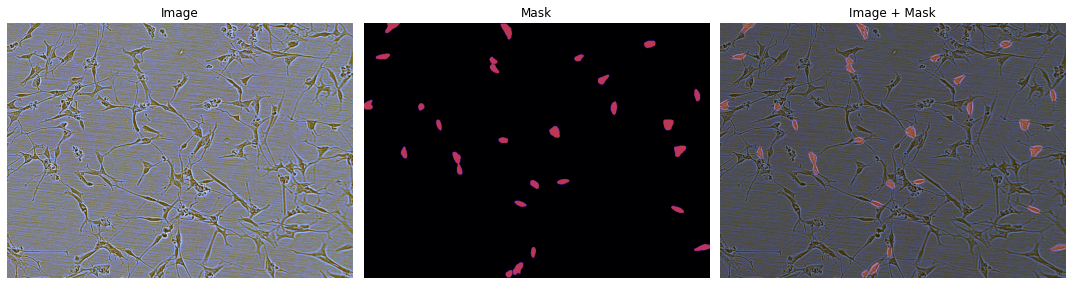

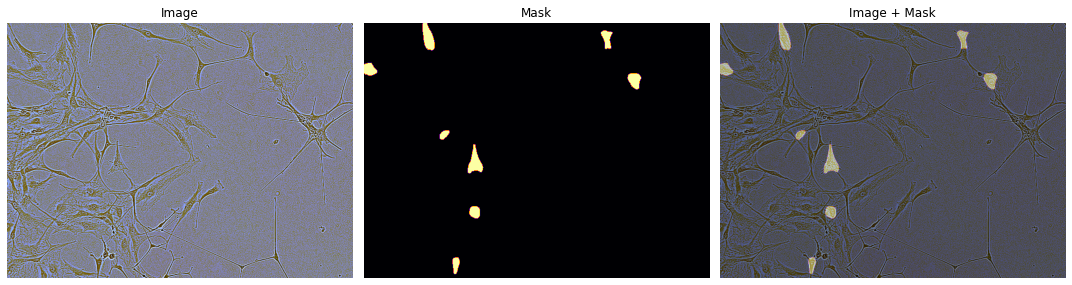

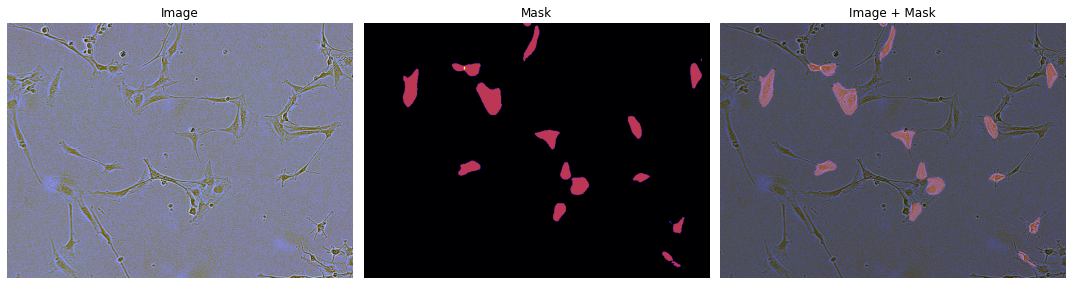

In [17]:
for ii in range(3):
    image_id = annos[ii]['filename'].replace('.jpg','').replace('.png','')
    for class_id in range(1):
        #print(ii,class_id,len(result[ii][0][class_id]), len(result[ii][1][class_id]))
        bbs = result[ii][0][class_id]
        sgs = result[ii][1][class_id]
        for idx, (bb, sg) in enumerate(zip(bbs,sgs)):
            box = bb[:4]
            cnf = bb[4]
            h = sg['size'][0]
            w = sg['size'][0]
            if cnf > 0.1:
#                 print(f'class_id:{class_id}, image_id:{image_id}, confidence:{cnf}')
                if idx==0:
                    mask = mutils.decode(sg)
                else:
                    mask+=mutils.decode(sg)
        print_masked_img(image_id, mask)

# Fix-Overlap
<pre>
The metric checks that the pairs are sorted, positive, and the decoded pixel values are not duplicated. It also checks that no two predicted masks for the same image are overlapping.
</pre>

In [18]:
import cupy as cp
import gc

def one_hot(y, num_classes, dtype=cp.uint8): # GPU
    y = cp.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = cp.max(y) + 1
    n = y.shape[0]
    categorical = cp.zeros((n, num_classes), dtype=dtype)
    categorical[cp.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = cp.reshape(categorical, output_shape)
    return categorical

def fix_overlap(msk): # GPU
    """
    Args:
        mask: multi-channel mask, each channel is an instance of cell, shape:(520,704,None)
    Returns:
        multi-channel mask with non-overlapping values, shape:(520,704,None)
    """
    msk = cp.array(msk)
    msk = cp.pad(msk, [[0,0],[0,0],[1,0]]) # add dummy mask for background
    ins_len = msk.shape[-1]
    msk = cp.argmax(msk,axis=-1)# convert multi channel mask to single channel mask, argmax will remove overlap
    msk = one_hot(msk, num_classes=ins_len) # back to multi-channel mask, some instance might get removed
    msk = msk[...,1:] # remove background mask
    msk = msk[...,cp.any(msk, axis=(0,1))] # remove all-zero masks
    #assert np.prod(msk, axis=-1).sum()==0 # overlap check, will raise error if there is overlap
    return msk

def check_overlap(msk):
    msk = msk.astype(cp.bool).astype(cp.uint8) # binary mask
    return cp.any(cp.sum(msk, axis=-1)>1) # only one channgel will contain value

# Submission

In [19]:
data = []
for ii in tqdm(range(len(annos))):
    image_id = annos[ii]['filename'].replace('.jpg','').replace('.png','')
    mask = []
    for class_id in range(1):
        bbs = result[ii][0][class_id]
        sgs = result[ii][1][class_id]
        for bb, sg in zip(bbs,sgs):
            box = bb[:4]
            cnf = bb[4]
            h = sg['size'][0]
            w = sg['size'][1]
            #convert coco format to kaggle format
            mask.append(cp.array(mutils.decode(sg)))
        mask = cp.stack(mask, axis=-1)
        if check_overlap(mask): # if mask instances have overlap then fix it
            mask = fix_overlap(mask)
        for idx in range(mask.shape[-1]):
            mask_ins = mask[...,idx]
            rle  = mask2rle(mask_ins)
            data.append([image_id, rle])
#             del mask_ins
#             gc.collect()
        del mask, rle, sgs, bbs
        gc.collect()
pred_df = pd.DataFrame(data, columns=['id','predicted'])

  0%|          | 0/3 [00:00<?, ?it/s]

In [20]:
sub_df  = pd.read_csv('../input/sartorius-cell-instance-segmentation/sample_submission.csv')
del sub_df['predicted']
sub_df = sub_df.merge(pred_df, on='id', how='left')
sub_df.to_csv('submission.csv',index=False)
sub_df.head()

,id,predicted
0,7ae19de7bc2a,140004 15 140707 19 141410 21 142114 21 142818...
1,7ae19de7bc2a,96419 3 97122 5 97826 6 98529 8 99233 8 99937 ...
2,7ae19de7bc2a,178194 3 178897 4 179600 6 180304 6 181007 7 1...
3,7ae19de7bc2a,148933 3 149634 8 150337 10 151040 11 151743 1...
4,7ae19de7bc2a,139542 3 140245 6 140948 8 141652 8 142356 9 1...


In [21]:
!ls -l 

total 20
---------- 1 root root   263 Dec 21 02:15 __notebook_source__.ipynb
-rw-r--r-- 1 root root 14797 Dec 21 03:10 submission.csv


# Reference
* [mmdetection for segmentation [inference]](https://www.kaggle.com/its7171/mmdetection-for-segmentation-inference) by @its7171

# Please Upvote If you find this notebook Useful :)